<a href="https://colab.research.google.com/github/digwit678/Can-Language-Models-Follow-Discussions/blob/main/Evaluating_Probing_Tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis of Language Model Performance on Probing Tasks

This notebook presents a structured analysis of language models' performance on various probing tasks, focusing on the difference in performance under permutation control tasks and across different model groups.

## Expectations Before Analysis
- **Model Groups**: GPT, BERT, and ELEKTRA are expected to show varying performances due to their different architectures and capabilities.
- **Permutation Task**: Significant performance differences in the permutation control task compared to the linguistic task (NONE) would suggest learning at the sentence level.

## Research Questions
1. Which properties are essential to be able to follow discussions?
2. What implicit understanding of a discussion can we expect from a language model? ,,
3. How can these properties be verified using probing tasks within language models?
4. How do different language models differ on these tasks and which of their properties are crucial for differences?


# Load Data

In [ ]:
!pip install matplotlib wandb seaborn

# Initialization

In [ ]:
#from google.colab import drive
GDRIVE_BASE_PATH = "/content/drive/MyDrive/Can Language Models Follow Discussions?/"
#drive.mount('/content/drive')

In [ ]:
SAVING_PATH_3 = 'probing_results/wandb_data_3.csv'

In [ ]:
PROJECT_NAMES = ["1_4_light_probes", "4_different_depths", "3_reactiveness", "5_claim_path_density", "1_opposing_affirming_claims", "2_Sequential-Claims-Hard"]
METRICS = ["full test f1", "full test acc"]
CONTROL_TASKS = ["RANDOMIZATION", "NONE", "PERMUTATION"]
MODELS = ['microsoft/deberta-v3-base', 'facebook/bart-base', 'gpt2', 'albert-base-v2', 'bert-base-uncased']
SEEDS = [0, 1, 2, 3, 4]
FOLDS = [0, 1, 2, 3]

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the CSV file containing the WandB data
wandb_data_path = 'probing_results/wandb_data_2.csv'
wandb_df = pd.read_csv(wandb_data_path)


In [ ]:
wandb_df.head()

,project,model,seed,fold,control_task,metric,value
0,1_1_affirming_opposing_light,microsoft/deberta-v3-base,1,3,PERMUTATION,full test f1,0.597360
1,1_1_affirming_opposing_light,microsoft/deberta-v3-base,1,3,PERMUTATION,full test acc,0.599378
2,1_1_affirming_opposing_light,microsoft/deberta-v3-base,4,2,PERMUTATION,full test f1,0.598910
3,1_1_affirming_opposing_light,microsoft/deberta-v3-base,4,2,PERMUTATION,full test acc,0.600488
4,1_1_affirming_opposing_light,microsoft/deberta-v3-base,4,3,PERMUTATION,full test f1,0.599023


In [ ]:
wandb_df['metric'] = wandb_df['metric'].astype(str)
wandb_df['model'] = wandb_df['model'].astype(str)
wandb_df['control_task'] = wandb_df['control_task'].astype(str)
wandb_df['project'] = wandb_df['project'].astype(str)

In [ ]:
wandb_df.dtypes

project          object
model            object
seed              int64
fold              int64
control_task     object
metric           object
value           float64
dtype: object

In [ ]:
#wandb_df.to_csv(f'{GDRIVE_BASE_PATH}/{SAVING_PATH_2}')

# TODO Metric for Evaluation
The choice between mean and median for performance evaluation depends on the data distribution. For symmetrically distributed data, mean is used; otherwise, median.

# Specific Models

## U-Test Linguistic Task (None) vs Permutation Control Task

In [ ]:
from scipy import stats

def perform_u_test(df, metric):
    """
    Performs Mann-Whitney U test between control tasks for each project.

    :param df: DataFrame containing the projects.
    :param metric: Metric to perform the U test on.
    :return: DataFrame with U test results.
    """
    u_test_results = []
    for project in df['project'].unique():
        for model in df['model'].unique():
            project_model_df = df[(df['project'] == project) & (df['model'] == model)]
            none_data = project_model_df[(project_model_df['control_task'] == 'NONE') & (project_model_df['metric'] == metric)]['value']
            permutation_data = project_model_df[(project_model_df['control_task'] == 'PERMUTATION') & (project_model_df['metric'] == metric)]['value']
            if len(none_data) > 0 and len(permutation_data) > 0:
                u_stat, p_value = stats.mannwhitneyu(none_data, permutation_data, alternative='two-sided')
                u_test_results.append({'project': project, 'model': model, 'u_stat': u_stat, 'p_value': p_value})
            else:
                u_test_results.append({'project': project, 'model': model, 'u_stat': None, 'p_value': None})

    return pd.DataFrame(u_test_results)


metric = 'full test f1'
u_test_results_f1 = perform_u_test(wandb_df, metric)
u_test_results_f1.head()


,project,model,u_stat,p_value
0,1_1_affirming_opposing_light,microsoft/deberta-v3-base,10000.0,2.509281e-34
1,1_1_affirming_opposing_light,facebook/bart-base,10100.0,1.725151e-34
2,1_1_affirming_opposing_light,gpt2,9999.0,2.536484e-34
3,1_1_affirming_opposing_light,albert-base-v2,10100.0,1.725151e-34
4,1_1_affirming_opposing_light,bert-base-uncased,10000.0,2.505748e-34


In [ ]:
metric = 'full test acc'
u_test_results_acc = perform_u_test(wandb_df, metric)
u_test_results_acc

,project,model,u_stat,p_value
0,1_1_affirming_opposing_light,microsoft/deberta-v3-base,10000.0,2.460531e-34
1,1_1_affirming_opposing_light,facebook/bart-base,10100.0,1.719480e-34
2,1_1_affirming_opposing_light,gpt2,9999.0,2.534626e-34
3,1_1_affirming_opposing_light,albert-base-v2,10100.0,1.720440e-34
4,1_1_affirming_opposing_light,bert-base-uncased,10000.0,2.490259e-34
5,1_opposing_affirming_claims,microsoft/deberta-v3-base,1283.0,9.382413e-01
6,1_opposing_affirming_claims,facebook/bart-base,1208.5,9.551121e-01
7,1_opposing_affirming_claims,gpt2,1321.0,3.965043e-01
8,1_opposing_affirming_claims,albert-base-v2,899.5,4.586585e-02
9,1_opposing_affirming_claims,bert-base-uncased,1356.0,2.739007e-01


In [ ]:

def perform_u_test_all_metrics(df, metrics, control_task):
    """
    Performs Mann-Whitney U test between control tasks for each project and metric.

    :param df: DataFrame containing the projects.
    :param METRICS: List of METRICS to perform the U test on.
    :return: DataFrame with U test results.
    """
    u_test_results = []
    for metric in METRICS:
        for project in df['project'].unique():
            for model in df['model'].unique():
                project_model_df = df[(df['project'] == project) & (df['model'] == model)]
                none_data = project_model_df[(project_model_df['control_task'] == 'NONE') & (project_model_df['metric'] == metric)]['value']
                permutation_data = project_model_df[(project_model_df['control_task'] == f'{control_task}') & (project_model_df['metric'] == metric)]['value']
                if len(none_data) > 0 and len(permutation_data) > 0:
                    u_stat, p_value = stats.mannwhitneyu(none_data, permutation_data, alternative='two-sided')
                    u_test_results.append({
                        'project': project,
                        'model': model,
                        'metric': metric,
                        'u_stat': u_stat,
                        'p_value': p_value,
                        f'different from {control_task}': p_value < 0.05
                    })
                else:
                    u_test_results.append({
                        'project': project,
                        'model': model,
                        'metric': metric,
                        'u_stat': None,
                        'p_value': None,
                        'different': None
                    })

    return pd.DataFrame(u_test_results)



In [ ]:
# Executing the function with the WandB DataFrame and the specified metrics
u_test_results_metrics = perform_u_test_all_metrics(wandb_df, METRICS,control_task='PERMUTATION')
# Display the first few rows of the resulting DataFrame
learn_on_token_level = u_test_results_metrics[ u_test_results_metrics[f'different from {control_task}']==False]
learn_on_token_level

,project,model,metric,u_stat,p_value,different from PERMUTATION
5,1_opposing_affirming_claims,microsoft/deberta-v3-base,full test f1,1489.0,0.142818,False
6,1_opposing_affirming_claims,facebook/bart-base,full test f1,1285.0,0.552151,False
7,1_opposing_affirming_claims,gpt2,full test f1,1181.0,0.896435,False
8,1_opposing_affirming_claims,albert-base-v2,full test f1,1028.0,0.280005,False
9,1_opposing_affirming_claims,bert-base-uncased,full test f1,1289.0,0.533491,False
20,4_different_depths,microsoft/deberta-v3-base,full test f1,989.0,0.941059,False
21,4_different_depths,facebook/bart-base,full test f1,1048.0,0.738014,False
22,4_different_depths,gpt2,full test f1,1011.0,0.997216,False
23,4_different_depths,albert-base-v2,full test f1,1057.0,0.690733,False
24,4_different_depths,bert-base-uncased,full test f1,975.0,0.863025,False


In [ ]:
learn_on_token_level.drop(['different from PERMUTATION'],axis=1).groupby(["project","model"]).mean(numeric_only=True)

u_stat   p_value
project                     model                                       
1_opposing_affirming_claims albert-base-v2             1028.00  0.280005
                            bert-base-uncased          1322.50  0.403696
                            facebook/bart-base         1246.75  0.753632
                            gpt2                       1251.00  0.646470
                            microsoft/deberta-v3-base  1386.00  0.540530
4_different_depths          albert-base-v2             1092.25  0.530940
                            bert-base-uncased          1010.25  0.807175
                            facebook/bart-base          961.25  0.558371
                            gpt2                       1025.75  0.915696
                            microsoft/deberta-v3-base  1099.75  0.540123
5_claim_path_density        facebook/bart-base         1030.00  0.182549

#### Visualizations

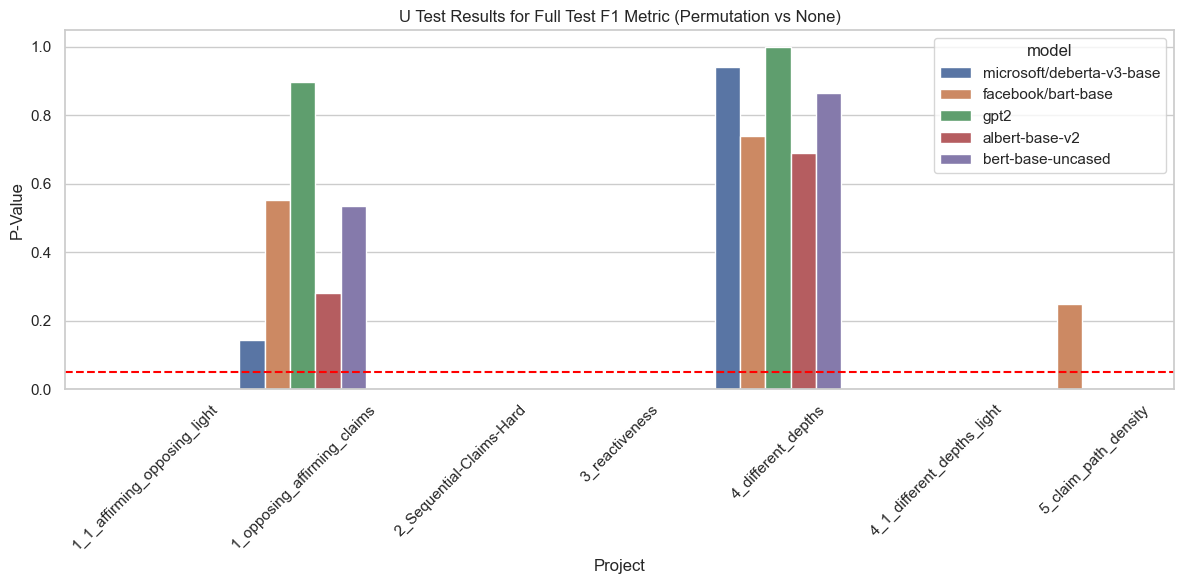

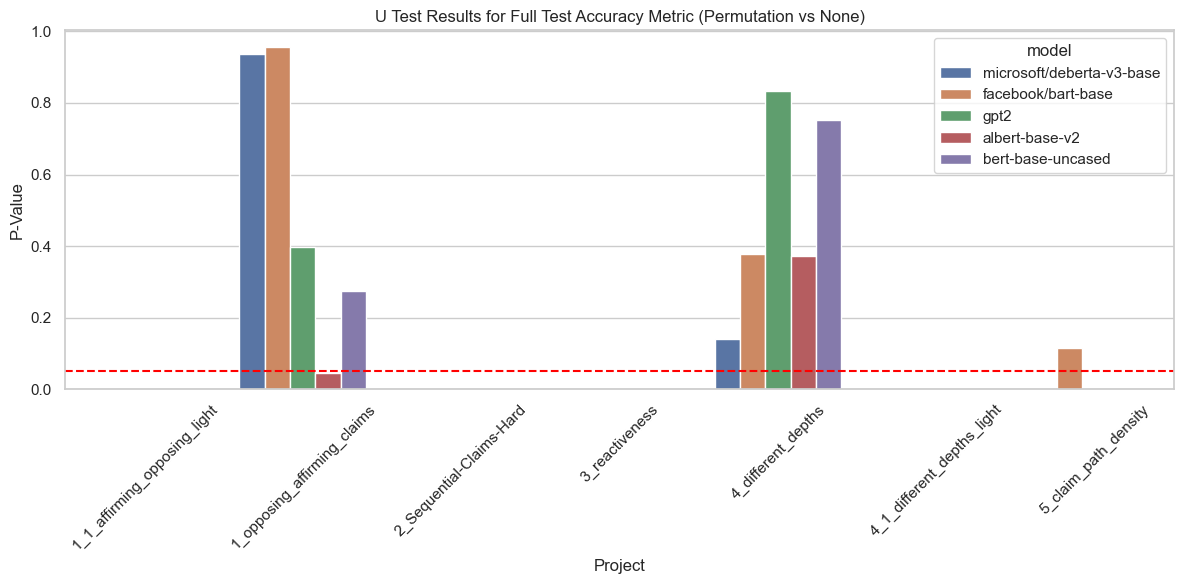

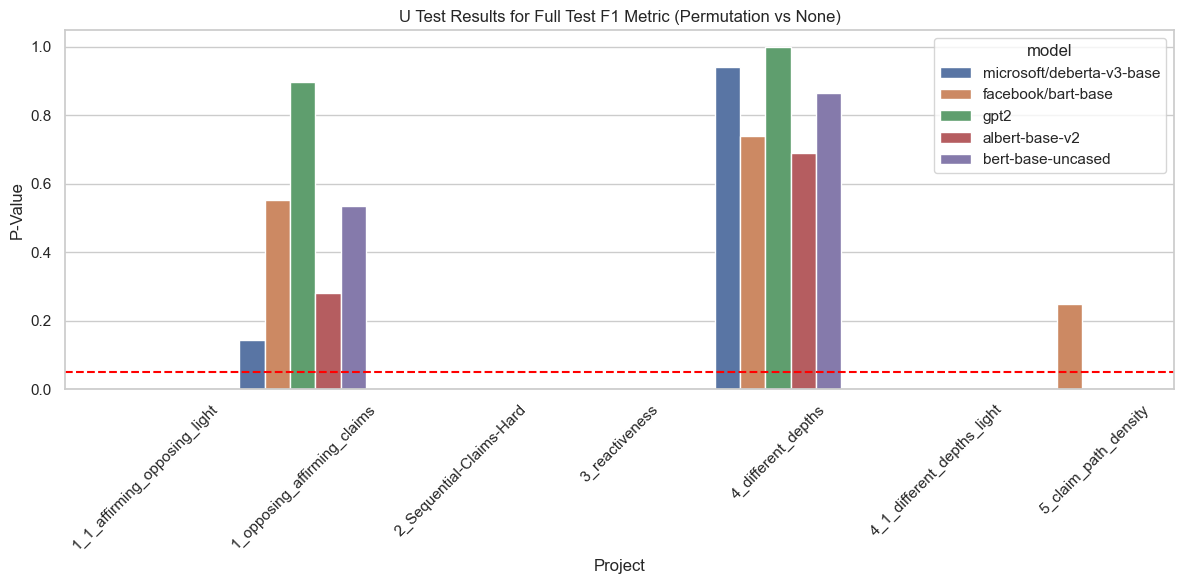

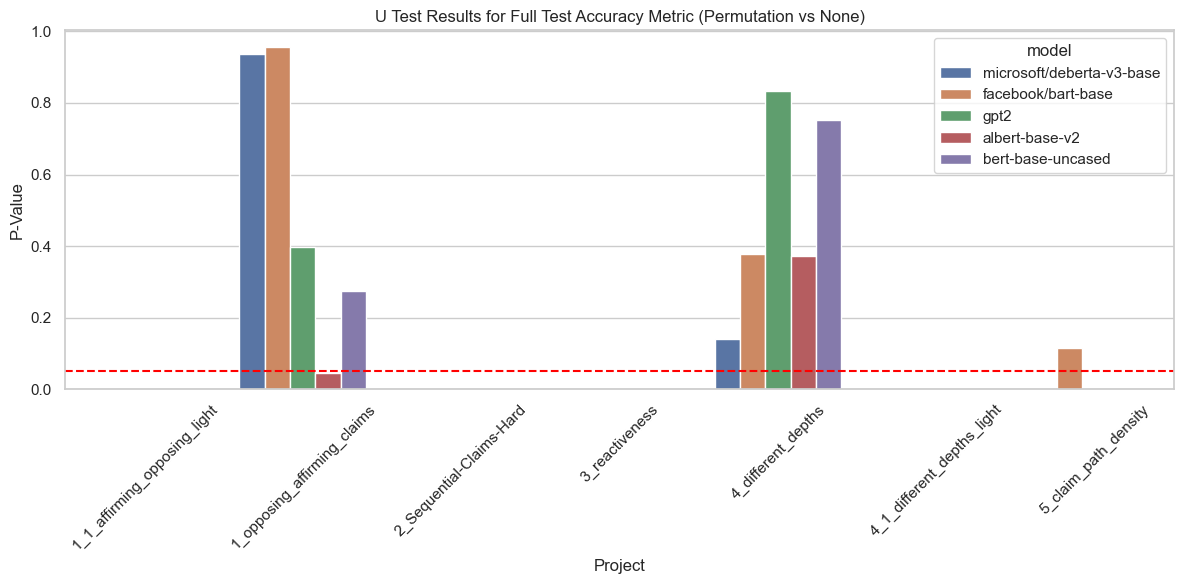

In [ ]:
# Creating visualizations for the U test results between control tasks (permutation vs none)
def plot_u_test_results(df, metric, title):
    """
    Plots the U test results for comparison between control tasks. Red Line indicates the significance level (p-value = 0.05).

    :param df: DataFrame containing U test results.
    :param metric: The metric to filter the results.
    :param title: The title for the plot.
    """
    filtered_df = df[df['metric'] == metric]
    plt.figure(figsize=(12, 6))
    sns.barplot(x='project', y='p_value', hue='model', data=filtered_df)
    plt.title(title)
    plt.xlabel('Project')
    plt.ylabel('P-Value')
    plt.axhline(0.05, ls='--', color='red')  # Significance level
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plotting U test results for 'full test f1' metric
plot_u_test_results(u_test_results_metrics, 'full test f1', 'U Test Results for Full Test F1 Metric (Permutation vs None)')

# Plotting U test results for 'full test acc' metric
plot_u_test_results(u_test_results_metrics, 'full test acc', 'U Test Results for Full Test Accuracy Metric (Permutation vs None)')

plot_u_test_results(u_test_results_metrics, 'full test f1', 'U Test Results for Full Test F1 Metric (Permutation vs None)')
plot_u_test_results(u_test_results_metrics, 'full test acc', 'U Test Results for Full Test Accuracy Metric (Permutation vs None)')


#### Observations for Permutation Control Task

By applying the U test for all metrics between the linguistic task (NONE) and the permutation control task, we can observe the following:

- Finding **stance types (1)** and **(unconstrained) abstract levels (2)** between claims are learned on a token basis for ***all models except for probing task 1 : albert-base-v2 the full test accuracy metric row is not present***.
- Determining the **distance and possibilities between claims (5)** is only learned on a token basis for ***facebook/bart-base***.

# Model Groups

Assign each model to its architectural group

In [ ]:
model_groups = {
    'GPT': ['gpt2'],
    'BERT': ['bert-base-uncased', 'facebook/bart-base', 'albert-base-v2'],
    'ELEKTRA': ['microsoft/deberta-v3-base']
}

# Function to assign each model to its group
def assign_model_group(model_name):
    for group, models in model_groups.items():
        if model_name in models:
            return group
    return "Unknown"

# Assigning model groups to each entry in the DataFrame
wandb_df['model_group'] = wandb_df['model'].apply(assign_model_group)

### Probing Tasks Performance Visualizations (All CT)

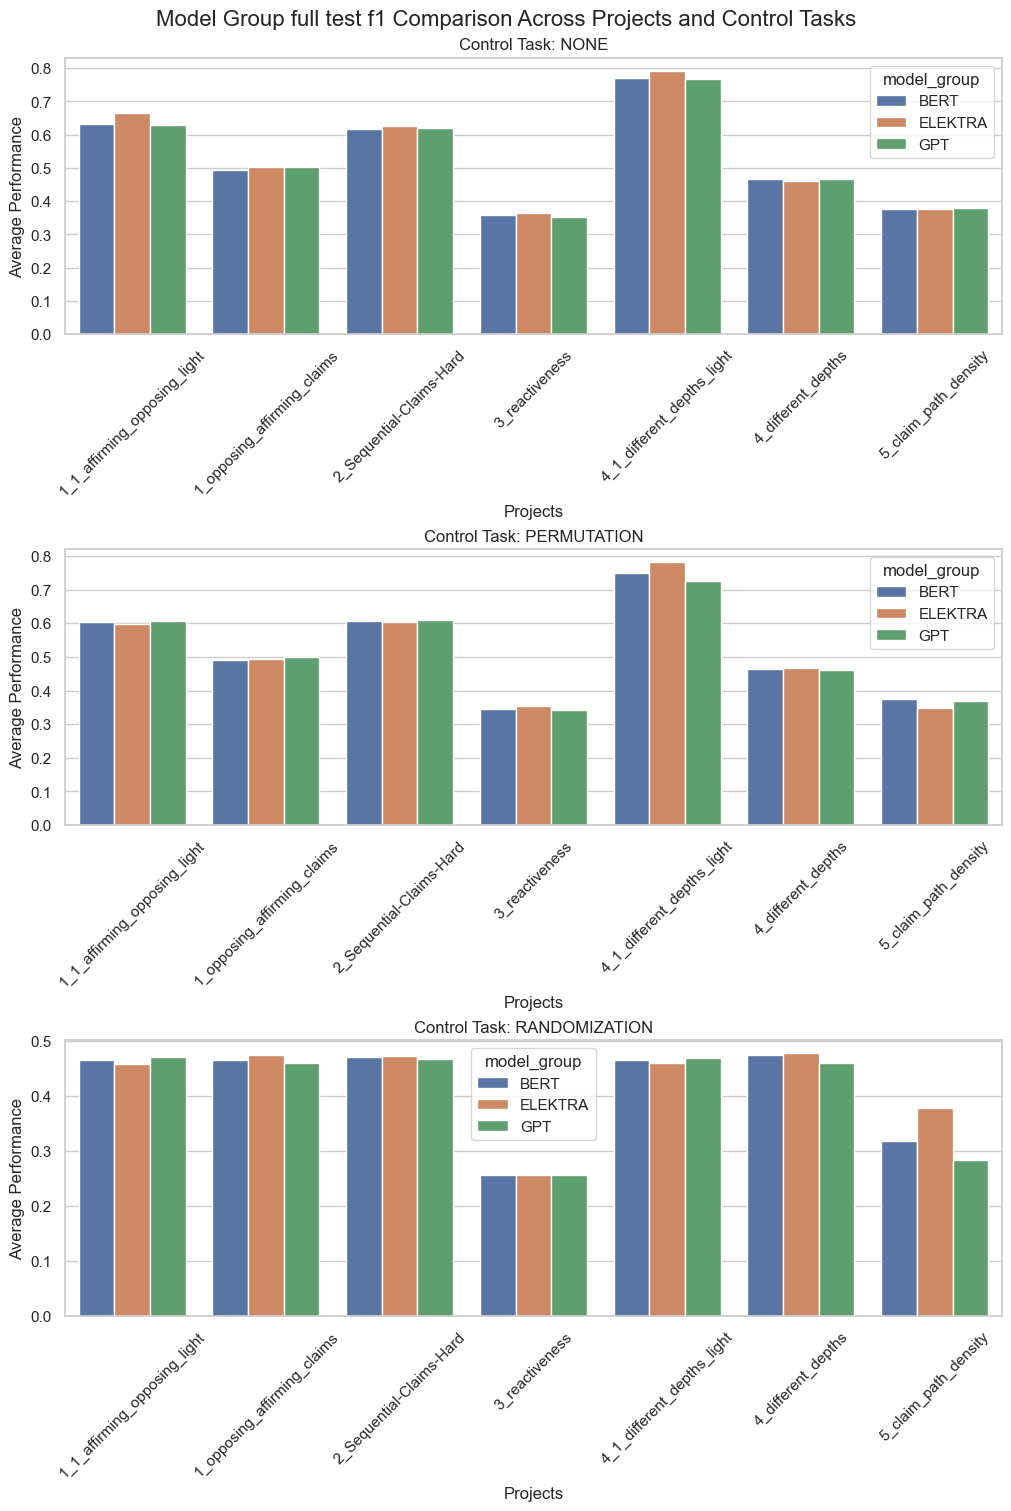

In [ ]:
# Grouping data by control task, project, model group, and metric
grouped_data_project = wandb_df.groupby(['control_task', 'project', 'model_group', 'metric']).mean(
    numeric_only=True).reset_index()

# Displaying the grouped data
grouped_data_project.head()

metric = 'full test f1'
sns.set(style="whitegrid")

# Plotting performance comparison for each control task type
control_tasks = grouped_data_project['control_task'].unique()
model_groups = ['GPT', 'BERT', 'ELEKTRA']  # Assuming these are your model groups

fig, axes = plt.subplots(nrows=len(control_tasks), ncols=1, figsize=(10, 15), constrained_layout=True)
fig.suptitle(f'Model Group {metric} Comparison Across Projects and Control Tasks', fontsize=16)

for i, control_task in enumerate(control_tasks):
    # Filtering data for the specific control task
    task_data = grouped_data_project[
        (grouped_data_project['control_task'] == control_task) & (grouped_data_project['metric'] == metric)]

    sns.barplot(x='project', y='value', hue='model_group', data=task_data, ax=axes[i])
    axes[i].set_title(f'Control Task: {control_task}')
    axes[i].set_xlabel('Projects')
    axes[i].set_ylabel('Average Performance')
    axes[i].tick_params(axis='x', rotation=45)

plt.show()


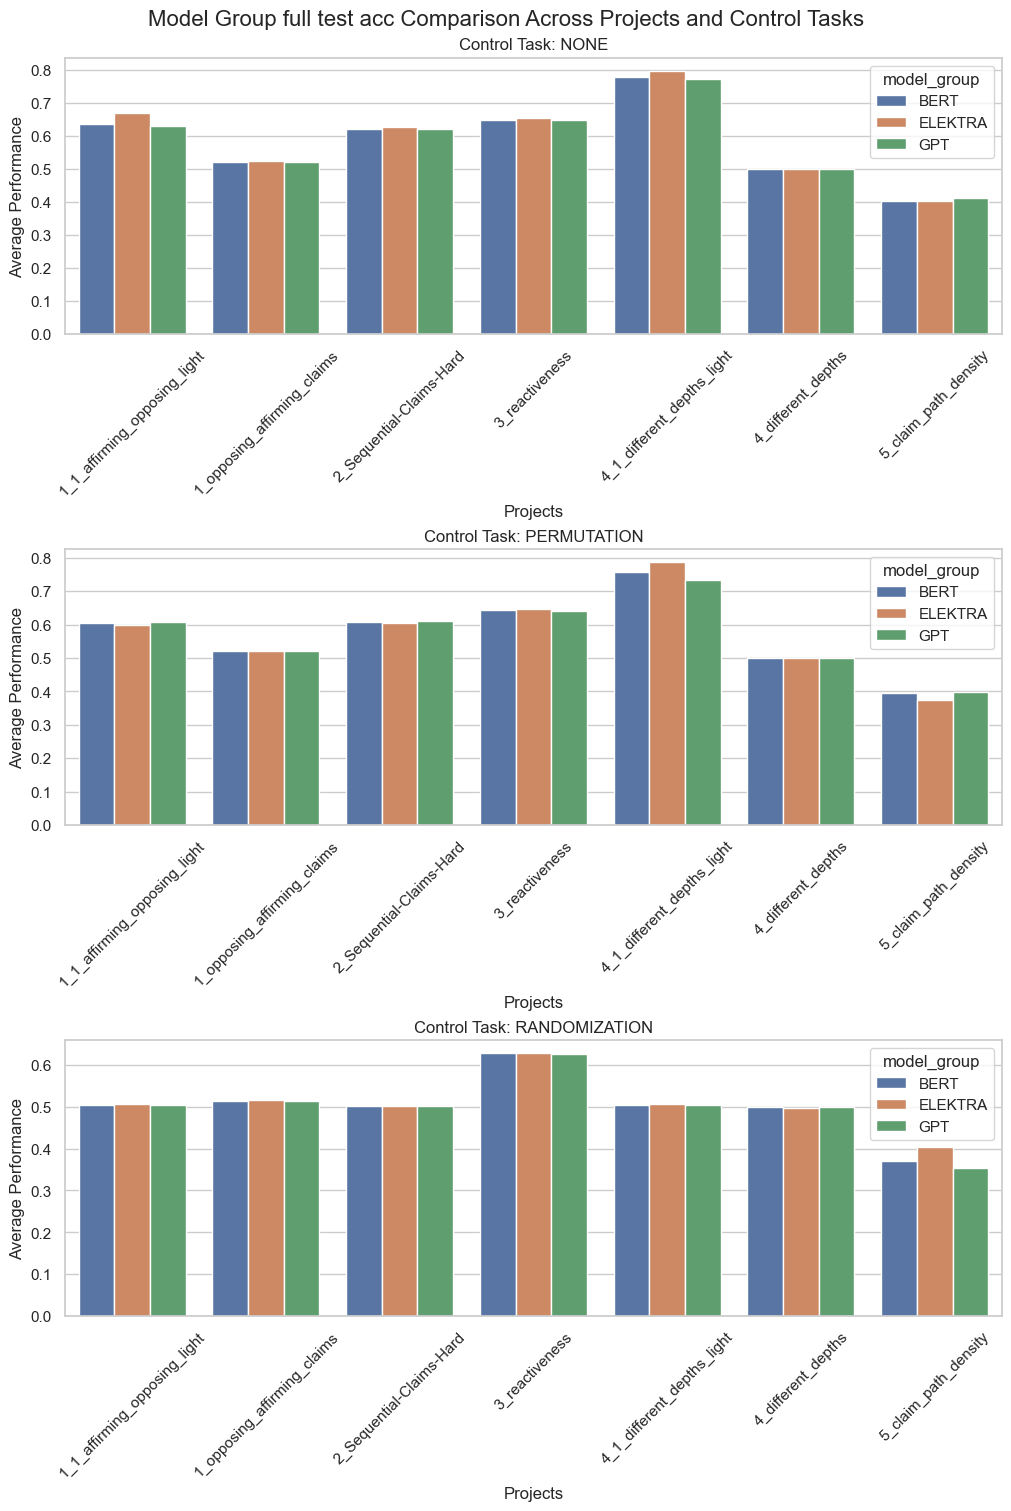

In [ ]:
metric = 'full test acc'
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=len(control_tasks), ncols=1, figsize=(10, 15), constrained_layout=True)
fig.suptitle(f'Model Group {metric} Comparison Across Projects and Control Tasks', fontsize=16)

for i, control_task in enumerate(control_tasks):
    # Filtering data for the specific control task
    task_data = grouped_data_project[
        (grouped_data_project['control_task'] == control_task) & (grouped_data_project['metric'] == metric)]

    sns.barplot(x='project', y='value', hue='model_group', data=task_data, ax=axes[i])
    axes[i].set_title(f'Control Task: {control_task}')
    axes[i].set_xlabel('Projects')
    axes[i].set_ylabel('Average Performance')
    axes[i].tick_params(axis='x', rotation=45)

plt.show()

In [ ]:
# Grouping data by control task and model, and calculating mean over all probing tasks
grouped_data_project = wandb_df.groupby(['control_task', 'model',"metric","project"]).mean(numeric_only=True).reset_index()

# Displaying the grouped data
grouped_data_project.head()

,control_task,model,metric,project,seed,fold,value
0,NONE,albert-base-v2,full test acc,1_1_affirming_opposing_light,2.0,1.5,0.630479
1,NONE,albert-base-v2,full test acc,1_opposing_affirming_claims,2.0,1.5,0.520560
2,NONE,albert-base-v2,full test acc,2_Sequential-Claims-Hard,2.0,1.5,0.616906
3,NONE,albert-base-v2,full test acc,3_reactiveness,2.0,1.5,0.646809
4,NONE,albert-base-v2,full test acc,4_1_different_depths_light,2.0,1.5,0.774488


#### Zoom in TODO

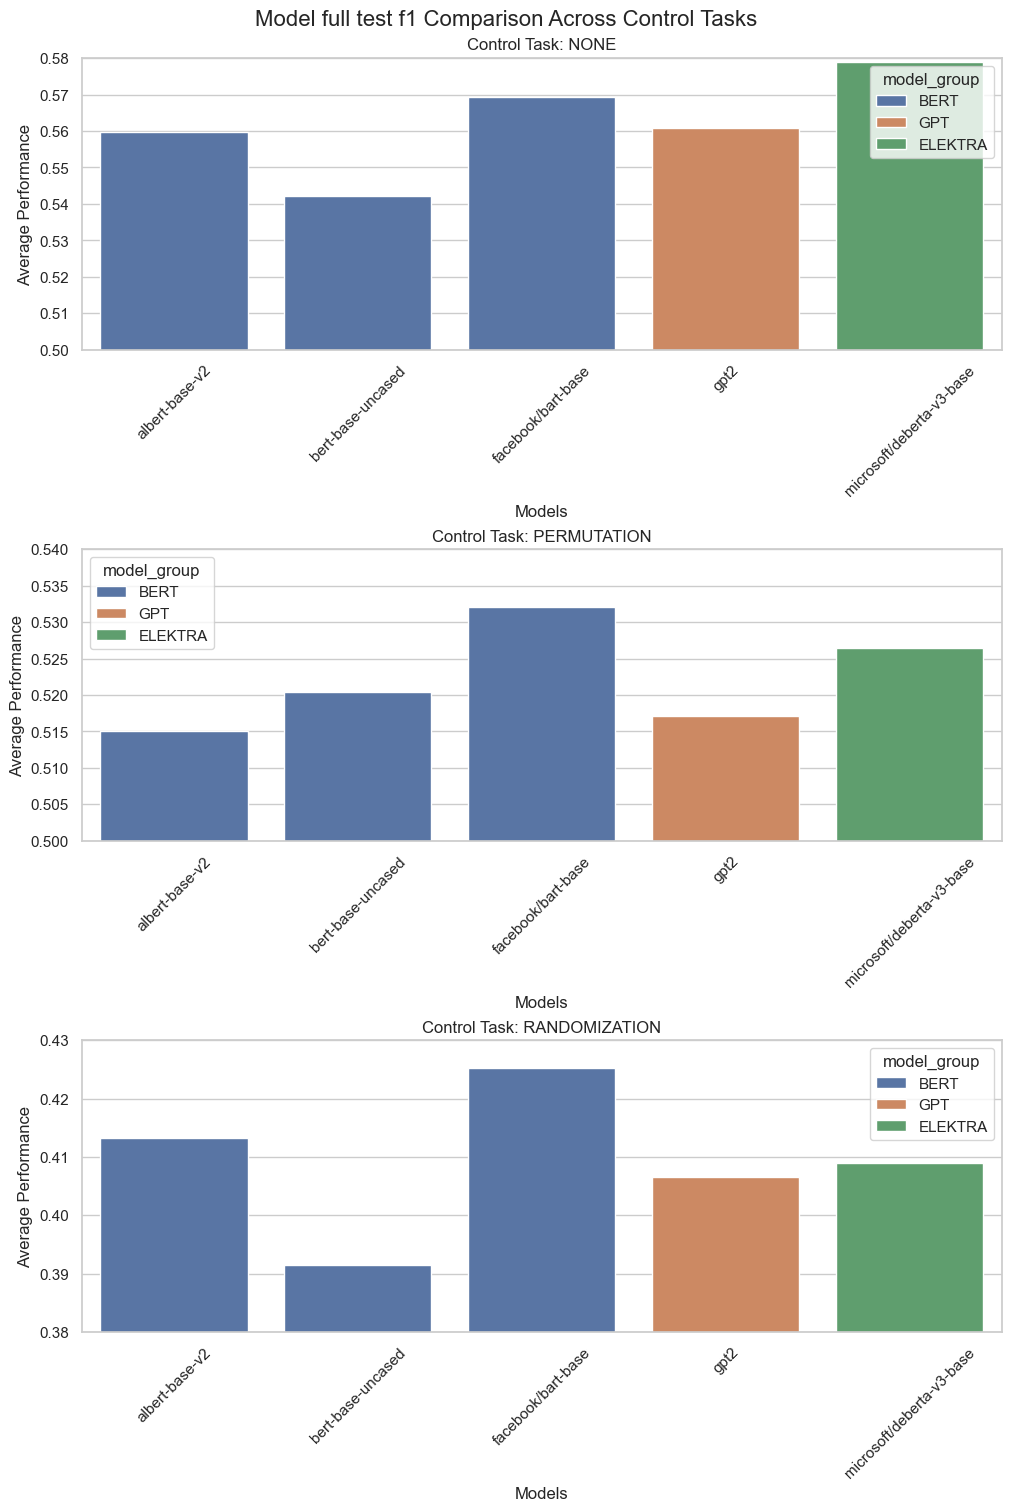

In [ ]:
metric = 'full test f1'
sns.set(style="whitegrid")

# Plotting performance comparison for each control task type
control_tasks = grouped_data_model['control_task'].unique()
#model_groups = list(model_groups.keys())

fig, axes = plt.subplots(nrows=len(control_tasks), ncols=1, figsize=(10, 15), constrained_layout=True)
fig.suptitle(f'Model {metric} Comparison Across Control Tasks', fontsize=16)

for i, control_task in enumerate(control_tasks):
    # Filtering data for the specific control task
    task_data = grouped_data_model[(grouped_data_model['control_task'] == control_task) & (grouped_data_model['metric'] == metric),""]

    sns.barplot(x='model', y='value', hue='model_group', data=task_data, ax=axes[i])
    axes[i].set_title(f'Control Task: {control_task}')
    axes[i].set_xlabel('Models')
    axes[i].set_ylabel('Average Performance')
    if i == 0:
        axes[i].set_ylim(0.5, 0.58)
    if i == 1:
        axes[i].set_ylim(0.5, 0.54)
    if i == 2:
        axes[i].set_ylim(0.38, 0.43)
    axes[i].tick_params(axis='x', rotation=45)

plt.show()


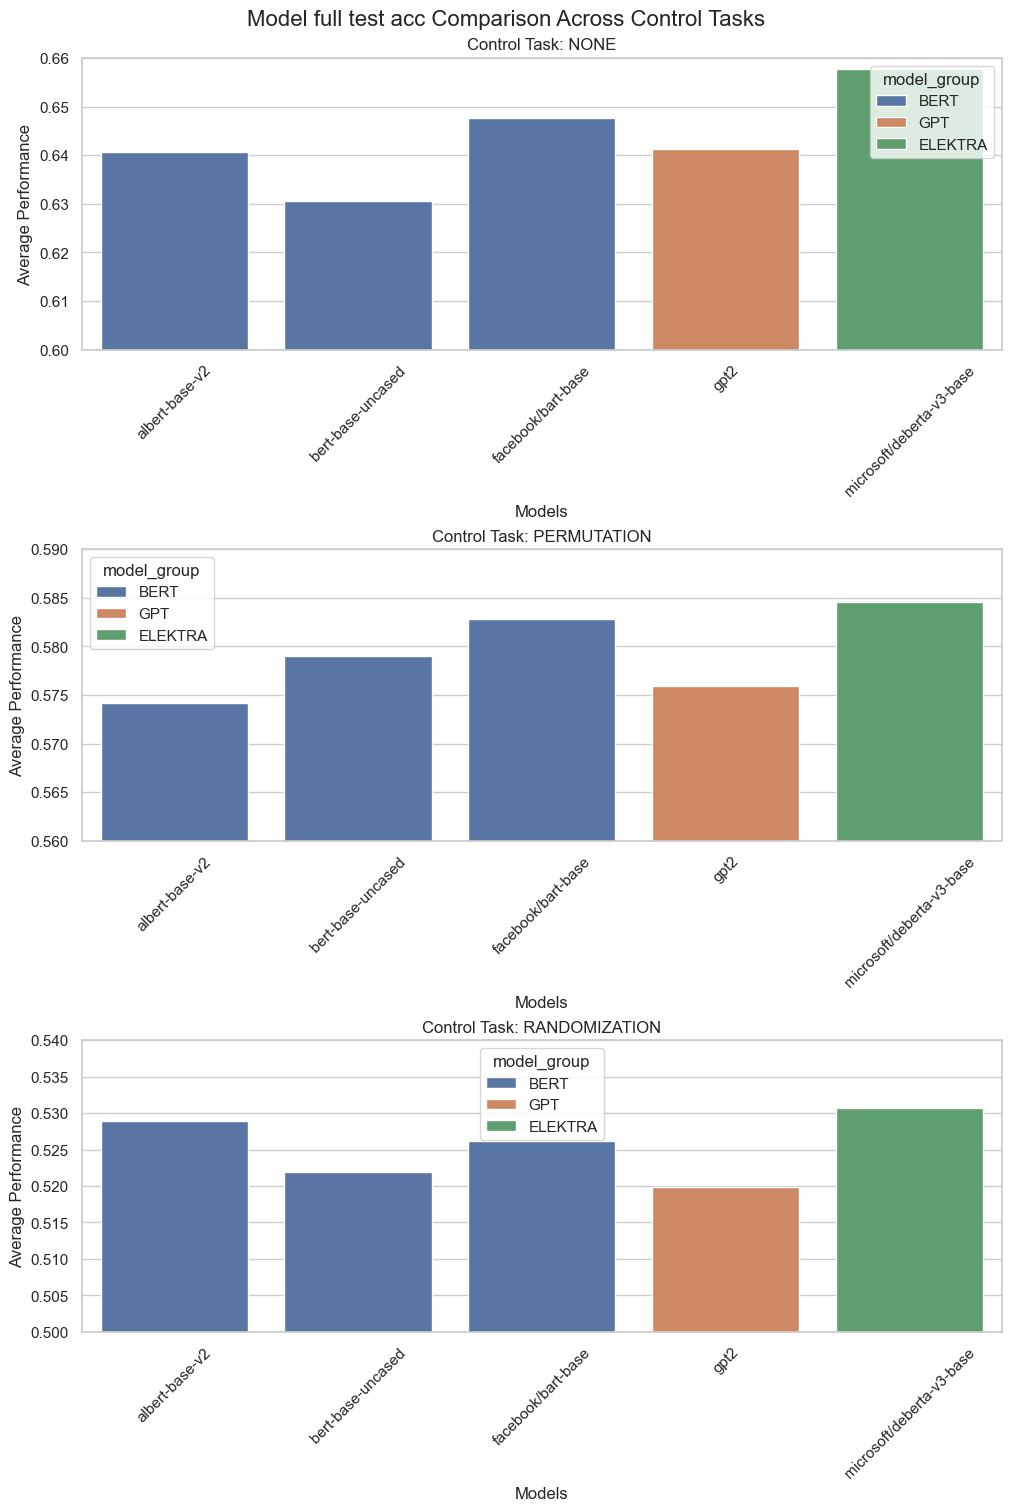

In [ ]:
metric = 'full test acc'
sns.set(style="whitegrid")

# Plotting performance comparison for each control task type
control_tasks = grouped_data_model['control_task'].unique()
#model_groups = list(model_groups.keys())

fig, axes = plt.subplots(nrows=len(control_tasks), ncols=1, figsize=(10, 15), constrained_layout=True)
fig.suptitle(f'Model {metric.upper()} Comparison Across Control Tasks', fontsize=16)


for i, control_task in enumerate(control_tasks):
    # Filtering data for the specific control task
    task_data = grouped_data_model[(grouped_data_model['control_task'] == control_task) & (grouped_data_model['metric'] == metric)]

    sns.barplot(x='model', y='value', hue='model_group', data=task_data, ax=axes[i])
    axes[i].set_title(f'Control Task: {control_task}')
    axes[i].set_xlabel('Models')
    axes[i].set_ylabel('Average Performance')
    if i == 0:
        axes[i].set_ylim(0.6, 0.66)
    if i == 1:
        axes[i].set_ylim(0.56, 0.59)
    if i == 2:
        axes[i].set_ylim(0.5, 0.54)

    axes[i].tick_params(axis='x', rotation=45)

plt.show()


### Average per Project

In [ ]:
# Metrics to consider
metrics = ['full test f1', 'full test acc']

# Creating summary tables for each metric and control task type
summary_tables = {metric: {} for metric in metrics}

for metric in metrics:
    for control_task in grouped_data_project['control_task'].unique():
        # Filtering data for the specific metric and control task
        filtered_data = grouped_data_project[(grouped_data_project['metric'] == metric) &
                                             (grouped_data_project['control_task'] == control_task)]

        # Pivot table for each metric and control task
        summary_table = filtered_data.pivot_table(index='project', columns='model_group', values='value', aggfunc='mean')

        # Storing the pivot table in the dictionary
        summary_tables[metric][control_task] = summary_table


example_control_task = list(summary_tables[metrics[0] ].keys())[0]

print(f"Summary table for metric: '{metrics[0] }' and control task: '{example_control_task}'")
summary_tables[example_metric][example_control_task]


Summary table for metric: 'full test f1' and control task: 'NONE'


model_group,BERT,ELEKTRA,GPT
project,,,
1_1_affirming_opposing_light,0.632999,0.666752,0.629300
1_opposing_affirming_claims,0.492625,0.501441,0.502505
2_Sequential-Claims-Hard,0.618124,0.624867,0.620966
3_reactiveness,0.357736,0.365424,0.353475
4_1_different_depths_light,0.771454,0.791002,0.766878
4_different_depths,0.467652,0.459460,0.467734
5_claim_path_density,0.377704,0.377769,0.378276


In [ ]:
example_control_task = list(summary_tables[metrics[1]].keys())[0]

print(f"Summary table for metric: '{metrics[1] }' and control task: '{example_control_task}'")
summary_tables[example_metric][example_control_task]

Summary table for metric: 'full test acc' and control task: 'NONE'


model_group,BERT,ELEKTRA,GPT
project,,,
1_1_affirming_opposing_light,0.632999,0.666752,0.629300
1_opposing_affirming_claims,0.492625,0.501441,0.502505
2_Sequential-Claims-Hard,0.618124,0.624867,0.620966
3_reactiveness,0.357736,0.365424,0.353475
4_1_different_depths_light,0.771454,0.791002,0.766878
4_different_depths,0.467652,0.459460,0.467734
5_claim_path_density,0.377704,0.377769,0.378276


### Control Tasks Averaged Across Projects (TODO set ylim)

Each metric visualized separately

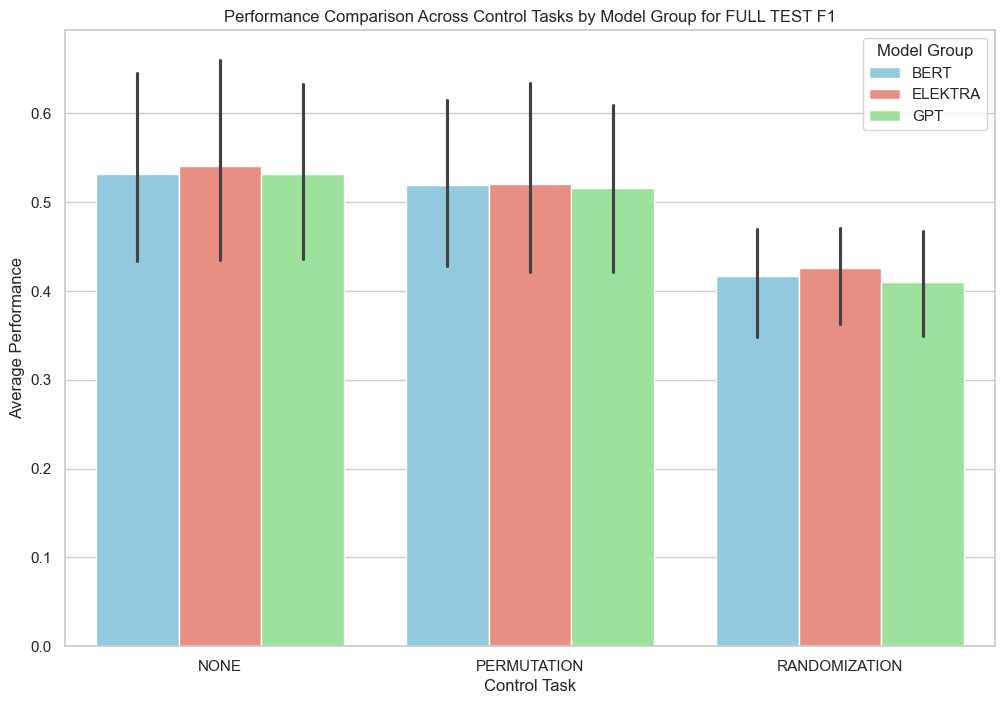

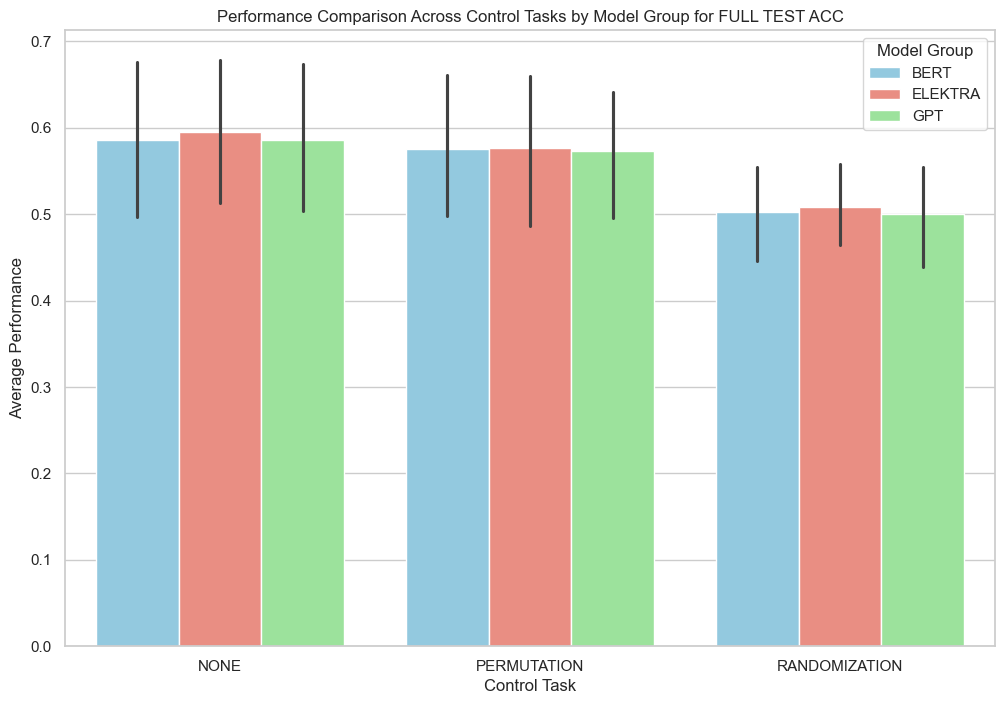

In [ ]:
colors = ["skyblue", "salmon", "lightgreen"]

metrics = ['full test f1', 'full test acc']

# Plotting for each metric
for metric in metrics:
    plt.figure(figsize=(12, 8))
    # Filtering data for the specific metric
    metric_data = grouped_data_project[grouped_data_project['metric'] == metric]

    sns.barplot(x='control_task', y='value', hue='model_group', data=metric_data, palette=colors)
    plt.title(f'Performance Comparison Across Control Tasks by Model Group for {metric.upper()}')
    plt.xlabel('Control Task')
    plt.ylabel('Average Performance')
    plt.legend(title='Model Group')
    plt.show()



Both metrics averaged

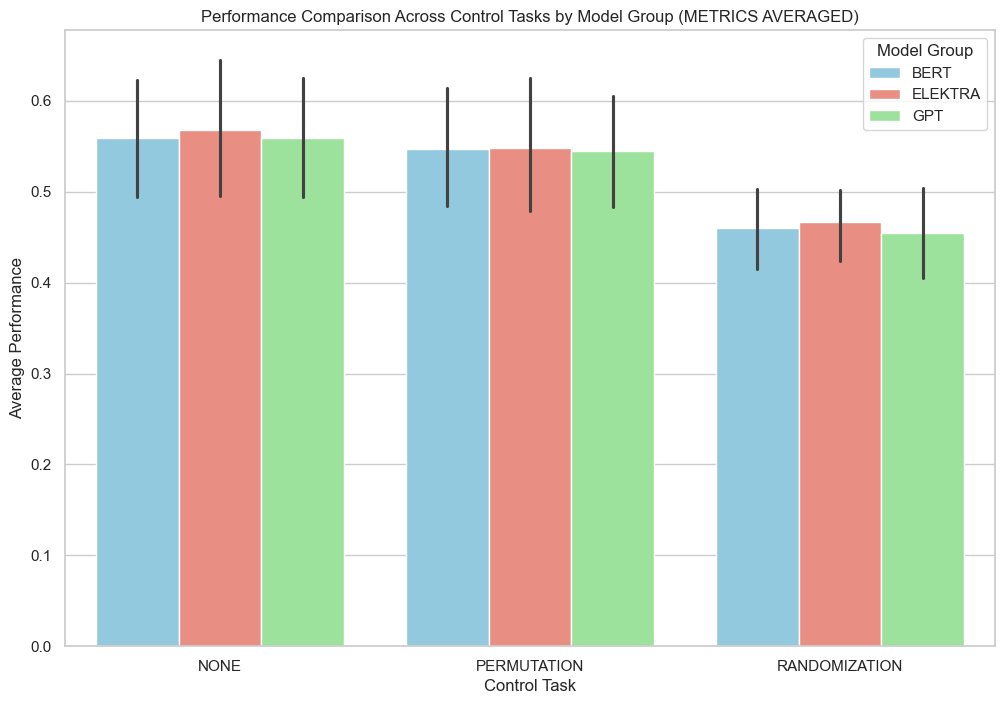

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='control_task', y='value', hue='model_group', data=grouped_data_project, palette=colors)
plt.title('Performance Comparison Across Control Tasks by Model Group (METRICS AVERAGED)')
plt.xlabel('Control Task')
plt.ylabel('Average Performance')
plt.legend(title='Model Group')
plt.show()

### U-Test for Control Tasks (2)

In [ ]:
model_groups = {
    'GPT': ['gpt2'],
    'BERT': ['bert-base-uncased', 'facebook/bart-base', 'albert-base-v2'],
    'ELEKTRA': ['microsoft/deberta-v3-base']
}

metrics = ['full test f1', 'full test acc']
control_task = 'PERMUTATION'
# Function to perform U test for model group comparisons
def perform_u_test_model_groups(df, metric, control_task, model_groups):
    """
    Performs Mann-Whitney U test between model groups for Permutation Control Task.
    :param df: DataFrame containing the data.
    :param metrics: List of metrics to perform the U test on.
    :param model_groups: Dictionary of model groups.
    :return: DataFrame with U test results.
    """
    u_test_results = []
    # Iterating through each combination of projects, metrics, and model groups
    for project in df['project'].unique():
            for group_name, models in model_groups.items():
                # Filtering the data for the current group, project, and metric
                group_data = df[(df['model'].isin(models)) & (df['project'] == project) & (df['metric'] == metric)]
                # Comparing 'NONE' vs 'PERMUTATION' or "RANDOMIZATION" for the current group
                linguistic_task_data = group_data[group_data['control_task'] == 'NONE']['value']
                control_task_data = group_data[group_data['control_task'] == f'{control_task}']['value']
                if len(linguistic_task_data) > 0 and len(control_task_data) > 0:
                    # Mann-Whitney U test
                    u_stat, p_value = stats.mannwhitneyu(linguistic_task_data, control_task_data, alternative='two-sided')
                    # Appending the results
                    u_test_results.append({
                        'project': project,
                        'model_group': group_name,
                        'metric': metric,
                        'u_stat': u_stat,
                        'p_value': p_value,
                        f'different to {control_task}': p_value < 0.05  # Boolean for significance
                    })

    return pd.DataFrame(u_test_results)

# Applying the adjusted U test function for a selected metric
u_test_results_f1_grouped =perform_u_test_model_groups(wandb_df, 'full test f1', f"{control_task}",model_groups)
u_test_results_acc_grouped = perform_u_test_model_groups(wandb_df, 'full test acc', f"{control_task}", model_groups)

In [ ]:
u_test_results_f1_grouped[u_test_results_f1_grouped[f"different to {control_task}"]==False]

,project,model_group,metric,u_stat,p_value,different to PERMUTATION
3,1_opposing_affirming_claims,GPT,full test f1,1181.0,0.896435,False
4,1_opposing_affirming_claims,BERT,full test f1,10805.0,0.929862,False
5,1_opposing_affirming_claims,ELEKTRA,full test f1,1489.0,0.142818,False
12,4_different_depths,GPT,full test f1,1011.0,0.997216,False
13,4_different_depths,BERT,full test f1,9274.0,0.710138,False
14,4_different_depths,ELEKTRA,full test f1,989.0,0.941059,False


In [ ]:
u_test_results_acc_grouped[u_test_results_acc_grouped[f"different to {control_task}"]==False]

,project,model_group,metric,u_stat,p_value,different to PERMUTATION
3,1_opposing_affirming_claims,GPT,full test acc,1321.0,0.396504,False
4,1_opposing_affirming_claims,BERT,full test acc,10310.0,0.557803,False
5,1_opposing_affirming_claims,ELEKTRA,full test acc,1283.0,0.938241,False
12,4_different_depths,GPT,full test acc,1040.5,0.834175,False
13,4_different_depths,BERT,full test acc,9086.0,0.907501,False
14,4_different_depths,ELEKTRA,full test acc,1210.5,0.139187,False


In [ ]:
u_test_results_f1_grouped

,project,model_group,metric,u_stat,p_value,different to PERMUTATION
0,1_1_affirming_opposing_light,GPT,full test f1,9999.0,2.536484e-34,True
1,1_1_affirming_opposing_light,BERT,full test f1,90601.0,4.940869e-100,True
2,1_1_affirming_opposing_light,ELEKTRA,full test f1,10000.0,2.509281e-34,True
3,1_opposing_affirming_claims,GPT,full test f1,1181.0,8.964348e-01,False
4,1_opposing_affirming_claims,BERT,full test f1,10805.0,9.298622e-01,False
5,1_opposing_affirming_claims,ELEKTRA,full test f1,1489.0,1.428184e-01,False
6,2_Sequential-Claims-Hard,GPT,full test f1,2000.0,1.946454e-12,True
7,2_Sequential-Claims-Hard,BERT,full test f1,17843.0,7.389676e-33,True
8,2_Sequential-Claims-Hard,ELEKTRA,full test f1,2020.0,1.863042e-12,True
9,3_reactiveness,GPT,full test f1,9586.0,3.835284e-29,True


#### Visualizations (REMOVE ??? TODO: ALL PROJEFCTS ??)

In [ ]:
# Plot U test results for model groups in the style of the provided image
def plot_u_test_results(df, metric, title, style='dark_background'):
    plt.style.use(style)
    filtered_df = df[df['metric'] == metric]
    plt.figure(figsize=(14, 6))
    sns.barplot(x='project', y='p_value', hue='model_group', data=filtered_df)
    plt.title(title)
    plt.xlabel('Project')
    plt.ylabel('P-Value')
    plt.axhline(0.05, ls='--', color='red')
    plt.legend(title='Model Group')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
u_test_results_acc_grouped

,project,model_group,metric,u_stat,p_value,different to PERMUTATION
0,1_1_affirming_opposing_light,GPT,full test acc,9999.0,2.534626e-34,True
1,1_1_affirming_opposing_light,BERT,full test acc,90601.0,4.931578e-100,True
2,1_1_affirming_opposing_light,ELEKTRA,full test acc,10000.0,2.460531e-34,True
3,1_opposing_affirming_claims,GPT,full test acc,1321.0,3.965043e-01,False
4,1_opposing_affirming_claims,BERT,full test acc,10310.0,5.578026e-01,False
5,1_opposing_affirming_claims,ELEKTRA,full test acc,1283.0,9.382413e-01,False
6,2_Sequential-Claims-Hard,GPT,full test acc,1997.0,2.262163e-12,True
7,2_Sequential-Claims-Hard,BERT,full test acc,17877.0,4.239364e-33,True
8,2_Sequential-Claims-Hard,ELEKTRA,full test acc,2020.0,1.861446e-12,True
9,3_reactiveness,GPT,full test acc,8526.0,6.969281e-18,True


note :
- the significant difference for probing task 5 is not visible (only for specific models since the mean is taken)
- Very small p-values are not visible (below red line 0.05 <=> significantly  different)

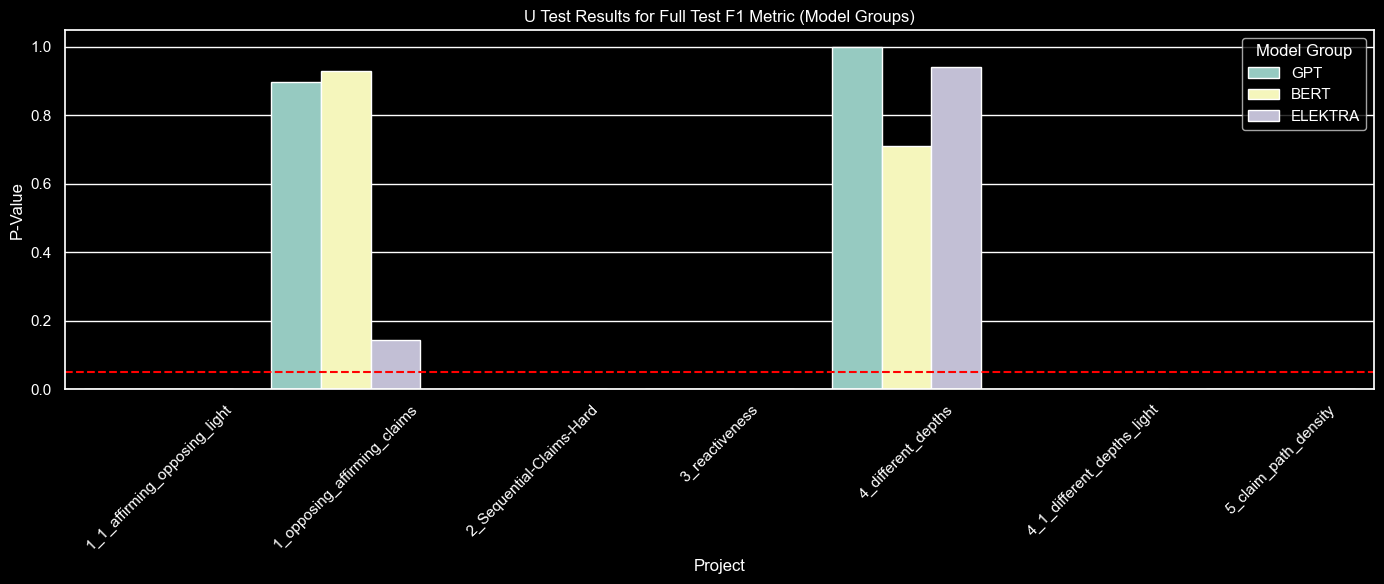

In [ ]:

# Plotting U test results for 'full test f1' metric
plot_u_test_results(u_test_results_f1_grouped, 'full test f1', 'U Test Results for Full Test F1 Metric (Model Groups)')

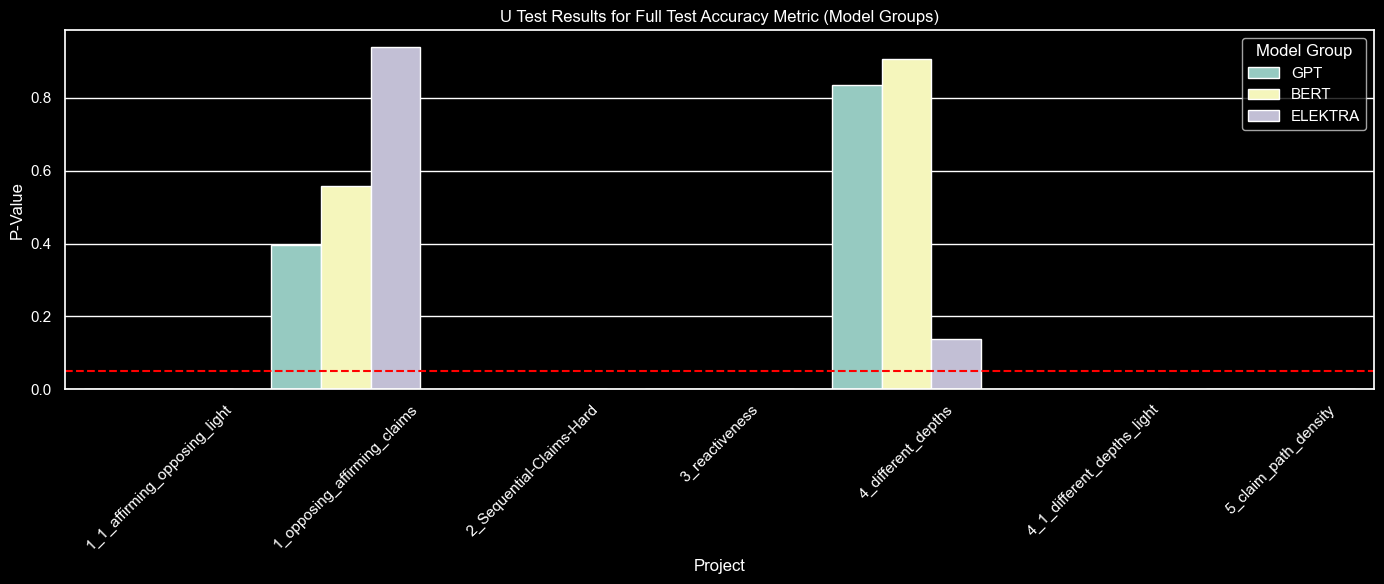

In [ ]:

# Plotting U test results for 'full test acc' metric
plot_u_test_results(u_test_results_acc_grouped, 'full test acc', 'U Test Results for Full Test Accuracy Metric (Model Groups)')

#### v2 TODO ZOOM

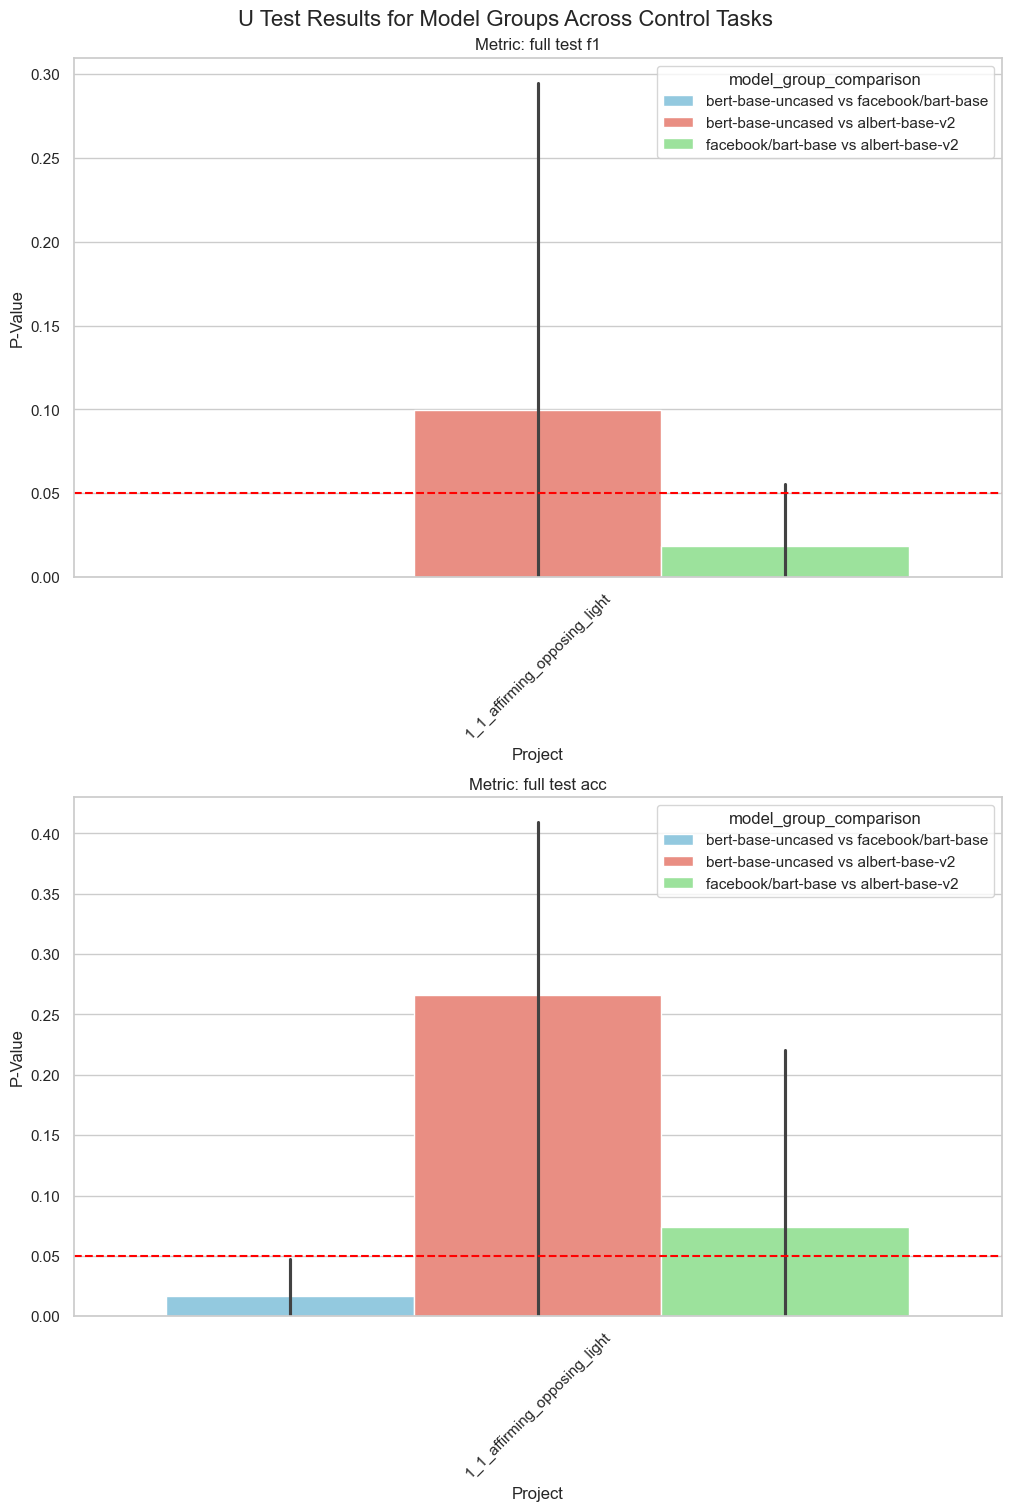

In [ ]:
# First, ensure the model_groups is a dictionary and the metrics is a list
model_groups = {
    'GPT': ['gpt2'],
    'BERT': ['bert-base-uncased', 'facebook/bart-base', 'albert-base-v2'],
    'ELEKTRA': ['microsoft/deberta-v3-base']
}

metrics = ['full test f1', 'full test acc']

# Define the perform_u_test_model_groups function to compute U test results for model groups
def perform_u_test_model_groups(df, metrics, model_groups):
    u_test_results = []
    for metric in metrics:
        for control_task in df['control_task'].unique():
            for group_name, models in model_groups.items():
                group_data = df[(df['model'].isin(models)) & (df['control_task'] == control_task) & (df['metric'] == metric)]
                if len(group_data) > 1:
                    # Compute pairwise U test for all combinations of models within the group
                    for i in range(len(models)):
                        for j in range(i+1, len(models)):
                            model_i_data = group_data[group_data['model'] == models[i]]['value']
                            model_j_data = group_data[group_data['model'] == models[j]]['value']
                            if not model_i_data.empty and not model_j_data.empty:
                                u_stat, p_value = stats.mannwhitneyu(model_i_data, model_j_data, alternative='two-sided')
                                u_test_results.append({
                                    'project': group_data['project'].iloc[0],  # assuming all rows have the same project name
                                    'control_task': control_task,
                                    'metric': metric,
                                    'model_group_comparison': f"{models[i]} vs {models[j]}",
                                    'u_stat': u_stat,
                                    'p_value': p_value
                                })

    return pd.DataFrame(u_test_results)

# Apply the perform_u_test_model_groups function on the wandb_df DataFrame
u_test_results_mgroups = perform_u_test_model_groups(wandb_df, metrics, model_groups)

# Now, let's visualize the U test results for model groups adapting the style from the image
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 15), constrained_layout=True)
fig.suptitle('U Test Results for Model Groups Across Control Tasks', fontsize=16)

# Iterate over each metric and plot the U test results for model groups
for i, metric in enumerate(metrics):
    # Filter the results for the current metric
    metric_data = u_test_results_mgroups[u_test_results_mgroups['metric'] == metric]
    sns.barplot(x='project', y='p_value', hue='model_group_comparison', data=metric_data, ax=axes[i], palette=["skyblue", "salmon", "lightgreen"])
    axes[i].set_title(f'Metric: {metric}')
    axes[i].set_xlabel('Project')
    axes[i].set_ylabel('P-Value')
    axes[i].axhline(0.05, ls='--', color='red')  # Significance level
    axes[i].tick_params(axis='x', rotation=45)

plt.show()


# Does the seed number influence the perfomance of the LLMs ? TODO interpret + summary df  

In [ ]:

# Next, let's check the influence of the seed value on the performance of the LLMs
# For this, we will use the aggregated data by seed (seed_agg_df_f1 and seed_agg_df_acc)
# We need to perform U tests between different seeds for each project and control task

# Since we haven't aggregated the data by seeds, let's do that first
seed_agg_df_f1 = wandb_df[wandb_df['metric'] == 'full test f1'].groupby(
    ['model', 'project', 'control_task', 'seed']
).agg({'value': 'mean'}).reset_index()


In [ ]:
from scipy import stats
import pandas as pd

# Assuming wandb_df is your DataFrame loaded from WANDB

# Function to perform a U test for seeds based on a specific metric
def perform_u_test_seeds(data, metric):
    """
    Perform U tests on aggregated data by seeds to check if seed influences performance for a specific metric.

    :param data: DataFrame with the data.
    :param metric: The metric to perform the U test on.
    :return: DataFrame with U test results.
    """
    u_test_results = []
    metric_data = data[data['metric'] == metric]
    for (model, project, control_task), group in metric_data.groupby(['model', 'project', 'control_task']):
        seeds = group['seed'].unique()
        for seed1 in seeds:
            for seed2 in seeds:
                if seed1 != seed2:
                    data1 = group[group['seed'] == seed1]['value']
                    data2 = group[group['seed'] == seed2]['value']
                    u_stat, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                    u_test_results.append({
                        'model': model,
                        'project': project,
                        'control_task': control_task,
                        'seed1': seed1,
                        'seed2': seed2,
                        'metric': metric,
                        'p_value': p_value,
                        'different': p_value < 0.05
                    })
    return pd.DataFrame(u_test_results)

# Apply the U test function for 'full test f1' metric
f1_seed_u_test_results = perform_u_test_seeds(wandb_df, 'full test f1')

# Apply the U test function for 'full test acc' metric
acc_seed_u_test_results = perform_u_test_seeds(wandb_df, 'full test acc')

# Displaying the U test results for each metric
print("U Test Results for 'full test f1' Metric:")
print(f1_seed_u_test_results.head())

print("\nU Test Results for 'full test acc' Metric:")
print(acc_seed_u_test_results.head())


U Test Results for 'full test f1' Metric:
            model                       project control_task  seed1  seed2  \
0  albert-base-v2  1_1_affirming_opposing_light         NONE      4      3   
1  albert-base-v2  1_1_affirming_opposing_light         NONE      4      2   
2  albert-base-v2  1_1_affirming_opposing_light         NONE      4      0   
3  albert-base-v2  1_1_affirming_opposing_light         NONE      4      1   
4  albert-base-v2  1_1_affirming_opposing_light         NONE      3      4   

         metric   p_value  different  
0  full test f1  1.000000      False  
1  full test f1  0.504795      False  
2  full test f1  0.504694      False  
3  full test f1  0.504694      False  
4  full test f1  1.000000      False  

U Test Results for 'full test acc' Metric:
            model                       project control_task  seed1  seed2  \
0  albert-base-v2  1_1_affirming_opposing_light         NONE      4      3   
1  albert-base-v2  1_1_affirming_opposing_light        

In [ ]:
# Optionally, filter to display only significant differences
significant_differences_seeds_f1 = f1_seed_u_test_results [f1_seed_u_test_results ["different"] == True]
significant_differences_seeds_f1

,model,project,control_task,seed1,seed2,metric,p_value,different
5,albert-base-v2,1_1_affirming_opposing_light,NONE,3,2,full test f1,0.042450,True
9,albert-base-v2,1_1_affirming_opposing_light,NONE,2,3,full test f1,0.042450,True
11,albert-base-v2,1_1_affirming_opposing_light,NONE,2,1,full test f1,0.042549,True
18,albert-base-v2,1_1_affirming_opposing_light,NONE,1,2,full test f1,0.042549,True
86,albert-base-v2,1_opposing_affirming_claims,PERMUTATION,0,3,full test f1,0.022576,True
...,...,...,...,...,...,...,...,...
1879,microsoft/deberta-v3-base,3_reactiveness,NONE,3,4,full test f1,0.042401,True
1923,microsoft/deberta-v3-base,4_1_different_depths_light,NONE,3,1,full test f1,0.042303,True
1936,microsoft/deberta-v3-base,4_1_different_depths_light,NONE,1,3,full test f1,0.042303,True
2070,microsoft/deberta-v3-base,5_claim_path_density,PERMUTATION,3,0,full test f1,0.042377,True


In [ ]:
f1_seed_u_test_results [f1_seed_u_test_results ["different"] == False]

,model,project,control_task,seed1,seed2,metric,p_value,different
0,albert-base-v2,1_1_affirming_opposing_light,NONE,4,3,full test f1,1.000000,False
1,albert-base-v2,1_1_affirming_opposing_light,NONE,4,2,full test f1,0.504795,False
2,albert-base-v2,1_1_affirming_opposing_light,NONE,4,0,full test f1,0.504694,False
3,albert-base-v2,1_1_affirming_opposing_light,NONE,4,1,full test f1,0.504694,False
4,albert-base-v2,1_1_affirming_opposing_light,NONE,3,4,full test f1,1.000000,False
...,...,...,...,...,...,...,...,...
2095,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,1,3,full test f1,0.885714,False
2096,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,3,4,full test f1,0.485714,False
2097,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,3,0,full test f1,0.485714,False
2098,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,3,2,full test f1,0.485714,False


In [ ]:
significant_differences_seeds_acc = acc_seed_u_test_results [acc_seed_u_test_results ["different"] == True]
significant_differences_seeds_acc

,model,project,control_task,seed1,seed2,metric,p_value,different
7,albert-base-v2,1_1_affirming_opposing_light,NONE,3,1,full test acc,0.042401,True
11,albert-base-v2,1_1_affirming_opposing_light,NONE,2,1,full test acc,0.006755,True
17,albert-base-v2,1_1_affirming_opposing_light,NONE,1,3,full test acc,0.042401,True
18,albert-base-v2,1_1_affirming_opposing_light,NONE,1,2,full test acc,0.006755,True
50,albert-base-v2,1_1_affirming_opposing_light,RANDOMIZATION,4,0,full test acc,0.018034,True
...,...,...,...,...,...,...,...,...
2012,microsoft/deberta-v3-base,4_different_depths,PERMUTATION,2,1,full test acc,0.002673,True
2015,microsoft/deberta-v3-base,4_different_depths,PERMUTATION,2,0,full test acc,0.004320,True
2017,microsoft/deberta-v3-base,4_different_depths,PERMUTATION,0,4,full test acc,0.003483,True
2018,microsoft/deberta-v3-base,4_different_depths,PERMUTATION,0,3,full test acc,0.029441,True


In [ ]:
acc_seed_u_test_results [acc_seed_u_test_results ["different"] == False]

,model,project,control_task,seed1,seed2,metric,p_value,different
0,albert-base-v2,1_1_affirming_opposing_light,NONE,4,3,full test acc,0.177497,False
1,albert-base-v2,1_1_affirming_opposing_light,NONE,4,2,full test acc,0.177807,False
2,albert-base-v2,1_1_affirming_opposing_light,NONE,4,0,full test acc,0.177704,False
3,albert-base-v2,1_1_affirming_opposing_light,NONE,4,1,full test acc,1.000000,False
4,albert-base-v2,1_1_affirming_opposing_light,NONE,3,4,full test acc,0.177497,False
...,...,...,...,...,...,...,...,...
2095,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,1,3,full test acc,0.885714,False
2096,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,3,4,full test acc,0.885714,False
2097,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,3,0,full test acc,0.885714,False
2098,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,3,2,full test acc,0.685714,False


In [ ]:
#acc_seed_u_test_results[acc_seed_u_test_results ["different"] == False] & f1_seed_u_test_results [f1_seed_u_test_results["different"] == False]

In [ ]:

# Now, let's create a function to perform U tests on these aggregated seed data

def perform_u_test_seeds(df, control_task, project):
    """
    Perform U tests on aggregated data by seeds to check if seed influences performance.

    :param df: DataFrame with aggregated seed data.
    :param control_task: Specific control task for the U test.
    :param project: Specific project for the U test.
    :return: DataFrame with U test results.
    """
    u_test_results = []
    seeds = df['seed'].unique()
    for i, seed1 in enumerate(seeds):
        for seed2 in seeds[i+1:]:
            seed1_data = df[(df['seed'] == seed1) & (df['control_task'] == control_task) & (df['project'] == project)]['value']
            seed2_data = df[(df['seed'] == seed2) & (df['control_task'] == control_task) & (df['project'] == project)]['value']
            if len(seed1_data) > 0 and len(seed2_data) > 0:
                u_stat, p_value = stats.mannwhitneyu(seed1_data, seed2_data, alternative='two-sided')
                u_test_results.append({
                    'project': project,
                    'control_task': control_task,
                    'seed1': seed1,
                    'seed2': seed2,
                    'p_value': p_value,
                    'different': p_value < 0.05
                })
    return pd.DataFrame(u_test_results)

# Apply the U test function for a sample project and control task to check seed influence
sample_project = seed_agg_df_f1['project'].iloc[0]
sample_control_task = seed_agg_df_f1['control_task'].iloc[0]
seed_u_test_results = perform_u_test_seeds(seed_agg_df_f1, sample_control_task, sample_project)

# Displaying the U test results for seed influence
seed_u_test_results.head()

In [ ]:
seed_u_test_results[seed_u_test_results["different"] == True]

,project,control_task,seed1,seed2,p_value,different


In [ ]:
print(seed_u_test_results[seed_u_test_results["p_value"] < 0.05])

Empty DataFrame
Columns: [project, control_task, seed1, seed2, p_value, different]
Index: []


### v0

In [ ]:
# Filter data for 'full test f1' metric and aggregate by seed
seed_agg_df_f1 = wandb_df[wandb_df['metric'] == 'full test f1'].groupby(['project', 'control_task','seed']).agg({'value': 'mean'}).reset_index()
# Filter data for 'full test acc' metric and aggregate by seed
seed_agg_df_acc = wandb_df[wandb_df['metric'] == 'full test acc'].groupby(['project','control_task', 'seed']).agg({'value': 'mean'}).reset_index()


seed_agg_df_f1.head()

seed_agg_df_acc.head()

,project,control_task,seed,value
0,1_1_affirming_opposing_light,NONE,0,0.641134
1,1_1_affirming_opposing_light,NONE,1,0.640413
2,1_1_affirming_opposing_light,NONE,2,0.641730
3,1_1_affirming_opposing_light,NONE,3,0.640527
4,1_1_affirming_opposing_light,NONE,4,0.639769


# Does the fold number influence the perfomance of the LLMs ? TODO interpret + summary df

TODO : forall Control Tasks ?

In [ ]:
def perform_u_test_folds(data, metric):
    """
    Perform U tests on aggregated data by folds to check if fold influences performance for a specific metric.

    :param data: DataFrame with the data.
    :param metric: The metric to perform the U test on.
    :return: DataFrame with U test results.
    """
    u_test_results = []
    metric_data = data[data['metric'] == metric]
    for (model, project, control_task), group in metric_data.groupby(['model', 'project', 'control_task']):
        folds = group['fold'].unique()
        for fold1 in folds:
            for fold2 in folds:
                if fold1 != fold2:
                    data1 = group[group['fold'] == fold1]['value']
                    data2 = group[group['fold'] == fold2]['value']
                    u_stat, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                    u_test_results.append({
                        'model': model,
                        'project': project,
                        'control_task': control_task,
                        'fold1': fold1,
                        'fold2': fold2,
                        'metric': metric,
                        'p_value': p_value,
                        'different': p_value < 0.05
                    })
    return pd.DataFrame(u_test_results)

# Apply the U test function for 'full test f1' metric
f1_fold_u_test_results = perform_u_test_folds(wandb_df, 'full test f1')

# Apply the U test function for 'full test acc' metric
acc_fold_u_test_results  = perform_u_test_folds(wandb_df, 'full test acc')

# Displaying the U test results for each metric
print("U Test Results for 'full test f1' Metric:")
print(f1_fold_u_test_results .head())

print("\nU Test Results for 'full test acc' Metric:")
print(acc_fold_u_test_results .head())


U Test Results for 'full test f1' Metric:
            model                       project control_task  fold1  fold2  \
0  albert-base-v2  1_1_affirming_opposing_light         NONE      1      2   
1  albert-base-v2  1_1_affirming_opposing_light         NONE      1      3   
2  albert-base-v2  1_1_affirming_opposing_light         NONE      1      0   
3  albert-base-v2  1_1_affirming_opposing_light         NONE      2      1   
4  albert-base-v2  1_1_affirming_opposing_light         NONE      2      3   

         metric       p_value  different  
0  full test f1  7.598006e-03       True  
1  full test f1  1.201657e-09       True  
2  full test f1  7.617241e-02      False  
3  full test f1  7.598006e-03       True  
4  full test f1  2.270229e-01      False  

U Test Results for 'full test acc' Metric:
            model                       project control_task  fold1  fold2  \
0  albert-base-v2  1_1_affirming_opposing_light         NONE      1      2   
1  albert-base-v2  1_1_affirmin

In [ ]:
significant_differences_folds_f1 = f1_fold_u_test_results [f1_fold_u_test_results ["different"] == True]
significant_differences_folds_f1

,model,project,control_task,fold1,fold2,metric,p_value,different
0,albert-base-v2,1_1_affirming_opposing_light,NONE,1,2,full test f1,7.598006e-03,True
1,albert-base-v2,1_1_affirming_opposing_light,NONE,1,3,full test f1,1.201657e-09,True
3,albert-base-v2,1_1_affirming_opposing_light,NONE,2,1,full test f1,7.598006e-03,True
5,albert-base-v2,1_1_affirming_opposing_light,NONE,2,0,full test f1,3.615075e-05,True
6,albert-base-v2,1_1_affirming_opposing_light,NONE,3,1,full test f1,1.201657e-09,True
...,...,...,...,...,...,...,...,...
1252,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,2,3,full test f1,1.587302e-02,True
1253,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,2,1,full test f1,7.936508e-03,True
1254,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,3,0,full test f1,7.936508e-03,True
1255,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,3,2,full test f1,1.587302e-02,True


In [ ]:
f1_fold_u_test_results [f1_fold_u_test_results ["different"] == False]

,model,project,control_task,fold1,fold2,metric,p_value,different
2,albert-base-v2,1_1_affirming_opposing_light,NONE,1,0,full test f1,0.076172,False
4,albert-base-v2,1_1_affirming_opposing_light,NONE,2,3,full test f1,0.227023,False
7,albert-base-v2,1_1_affirming_opposing_light,NONE,3,2,full test f1,0.227023,False
9,albert-base-v2,1_1_affirming_opposing_light,NONE,0,1,full test f1,0.076172,False
13,albert-base-v2,1_1_affirming_opposing_light,PERMUTATION,1,0,full test f1,0.180637,False
...,...,...,...,...,...,...,...,...
1247,microsoft/deberta-v3-base,5_claim_path_density,PERMUTATION,2,3,full test f1,0.085855,False
1250,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,0,1,full test f1,0.309524,False
1256,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,3,1,full test f1,0.055556,False
1257,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,1,0,full test f1,0.309524,False


In [ ]:
significant_differences_folds_acc = acc_fold_u_test_results [acc_fold_u_test_results ["different"] == True]
significant_differences_folds_acc

,model,project,control_task,fold1,fold2,metric,p_value,different
1,albert-base-v2,1_1_affirming_opposing_light,NONE,1,3,full test acc,1.201657e-09,True
2,albert-base-v2,1_1_affirming_opposing_light,NONE,1,0,full test acc,7.590696e-03,True
5,albert-base-v2,1_1_affirming_opposing_light,NONE,2,0,full test acc,2.895052e-02,True
6,albert-base-v2,1_1_affirming_opposing_light,NONE,3,1,full test acc,1.201657e-09,True
8,albert-base-v2,1_1_affirming_opposing_light,NONE,3,0,full test acc,1.201657e-09,True
...,...,...,...,...,...,...,...,...
1254,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,3,0,full test acc,7.936508e-03,True
1255,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,3,2,full test acc,7.936508e-03,True
1256,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,3,1,full test acc,1.587302e-02,True
1258,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,1,2,full test acc,7.936508e-03,True


In [ ]:
acc_fold_u_test_results [acc_fold_u_test_results ["different"] == False]


,model,project,control_task,fold1,fold2,metric,p_value,different
0,albert-base-v2,1_1_affirming_opposing_light,NONE,1,2,full test acc,0.226629,False
3,albert-base-v2,1_1_affirming_opposing_light,NONE,2,1,full test acc,0.226629,False
4,albert-base-v2,1_1_affirming_opposing_light,NONE,2,3,full test acc,0.814972,False
7,albert-base-v2,1_1_affirming_opposing_light,NONE,3,2,full test acc,0.814972,False
14,albert-base-v2,1_1_affirming_opposing_light,PERMUTATION,1,3,full test acc,0.050028,False
...,...,...,...,...,...,...,...,...
1223,microsoft/deberta-v3-base,4_different_depths,RANDOMIZATION,0,3,full test acc,0.841270,False
1226,microsoft/deberta-v3-base,5_claim_path_density,NONE,0,1,full test acc,0.841270,False
1233,microsoft/deberta-v3-base,5_claim_path_density,NONE,1,0,full test acc,0.841270,False
1250,microsoft/deberta-v3-base,5_claim_path_density,RANDOMIZATION,0,1,full test acc,0.841270,False


# Does the context influence the perfomance on the probing tasks ?

# TODO  FINAL SUMMARY TABLE